**Case Study: Fast Food**

Step 1: Deciding (not) to Segment

Step 2: Specifying the Ideal Target Segment

Step 3: Collecting Data



Step 4: Exploring Data

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')
(1453, 15)
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  
yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64
    Standard deviation  Pr

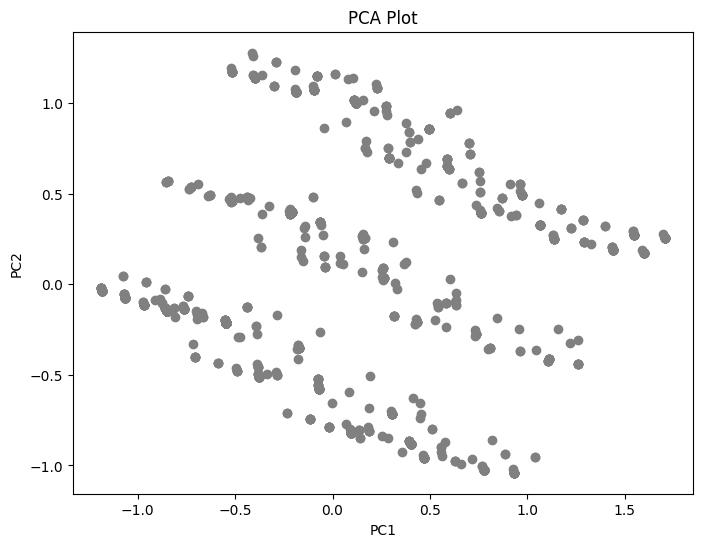

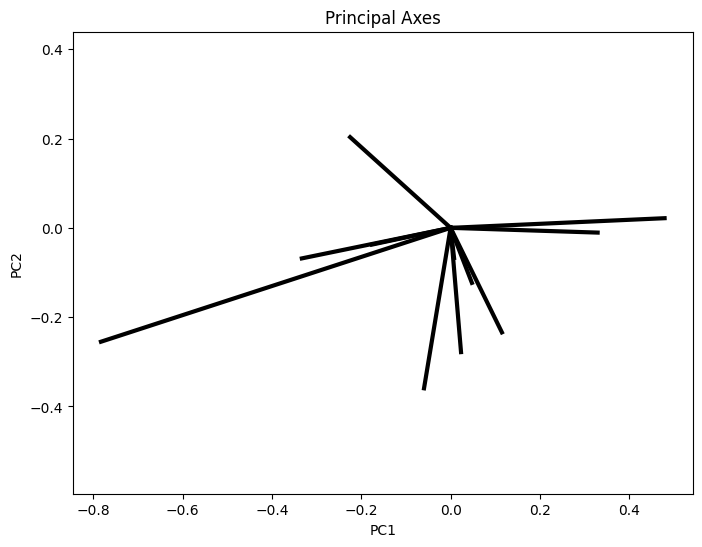

In [112]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
mcdonalds = pd.read_csv("https://homepage.boku.ac.at/leisch/MSA/datasets/mcdonalds.csv")  # Assuming the dataset is stored in a CSV file

# Check column names
print(mcdonalds.columns)

# Check dimensions
print(mcdonalds.shape)

# Display first 3 rows
print(mcdonalds.head(3))

# Convert selected columns to binary matrix
MD_x = mcdonalds.iloc[:, 0:11].apply(lambda x: (x == "Yes").astype(int))

# Calculate column means
print(np.round(MD_x.mean(), 2))

# Perform PCA
MD_pca = PCA()
MD_pca.fit(MD_x)

# Summary of PCA
print(pd.DataFrame({'Standard deviation': np.sqrt(MD_pca.explained_variance_),
                    'Proportion of Variance': MD_pca.explained_variance_ratio_,
                    'Cumulative Proportion': np.cumsum(MD_pca.explained_variance_ratio_)}))

# Print PCA results
print(pd.DataFrame(np.round(MD_pca.components_, 1), columns=mcdonalds.columns[0:11]))

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(MD_pca.transform(MD_x)[:, 0], MD_pca.transform(MD_x)[:, 1], color='grey')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot')
plt.show()

# Visualize principal axes
plt.figure(figsize=(8, 6))
for length, vector in zip(MD_pca.explained_variance_ratio_, MD_pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal Axes')
plt.axis('equal')
plt.show()

Step 5: Extracting Segments

 5.1 Using k-Means

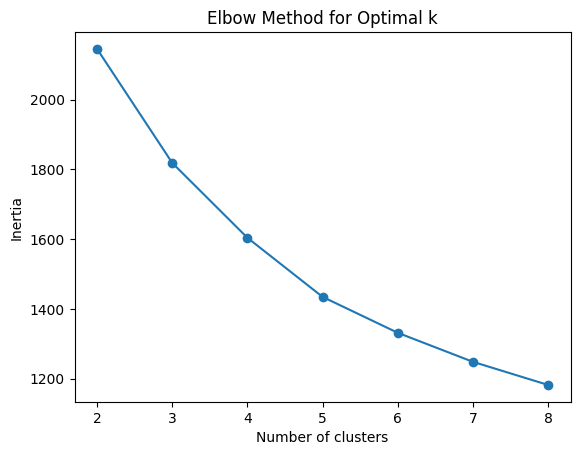

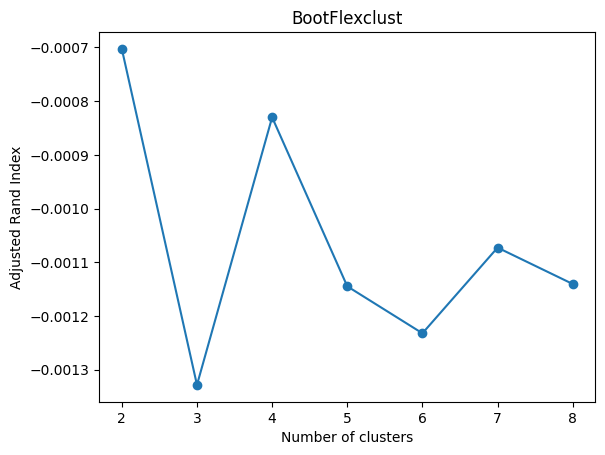

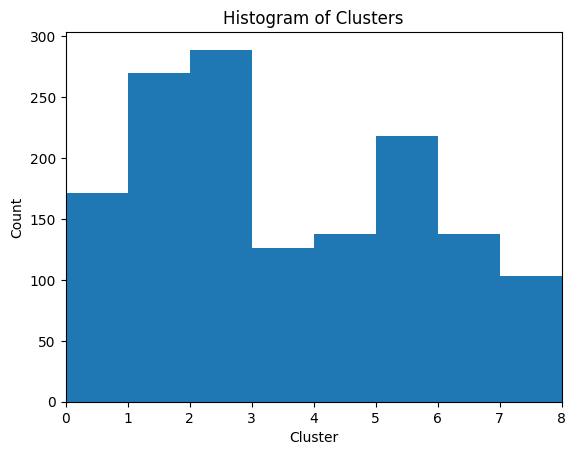

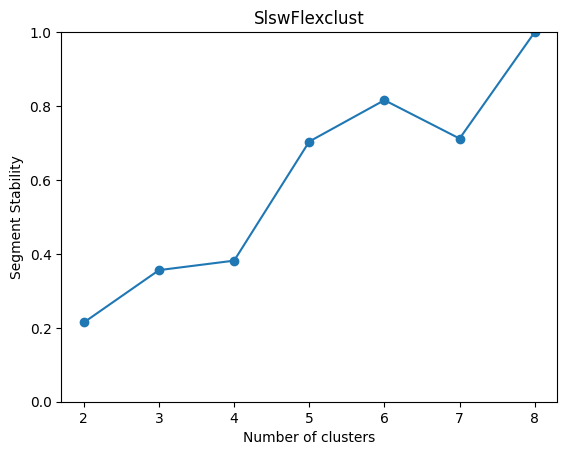

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

# Set seed
np.random.seed(1234)

# Assuming MD_x is your data, you should replace this with your actual data in Python

# StepFlexclust
inertia_values = []
for n_clusters in range(2, 9):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    inertia_values.append(kmeans.inertia_)

best_n_clusters = np.argmin(inertia_values) + 2

# Relabel
kmeans_best = KMeans(n_clusters=best_n_clusters, n_init=10, random_state=1234)
MD_k4_labels = kmeans_best.fit_predict(MD_x)

# Plot
plt.plot(range(2, 9), inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# BootFlexclust
adjusted_rand_indices = []
for n_clusters in range(2, 9):
    rand_indices = []
    for _ in range(100):
        boot_samples = resample(MD_x, random_state=1234)
        kmeans_boot = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
        boot_labels = kmeans_boot.fit_predict(boot_samples)
        rand_indices.append(adjusted_rand_score(MD_k4_labels, boot_labels))
    adjusted_rand_indices.append(np.mean(rand_indices))

# Plot
plt.plot(range(2, 9), adjusted_rand_indices, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Adjusted Rand Index')
plt.title('BootFlexclust')
plt.show()

# Histogram
plt.hist(MD_k4_labels, bins=range(best_n_clusters + 1))
plt.xlim(0, best_n_clusters)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Histogram of Clusters')
plt.show()

# SlswFlexclust
stability_values = []
for n_clusters in range(2, best_n_clusters + 1):
    kmeans_slsw = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    MD_r4_labels = kmeans_slsw.fit_predict(MD_x)
    stability_values.append(adjusted_rand_score(MD_k4_labels, MD_r4_labels))

# Plot
plt.plot(range(2, best_n_clusters + 1), stability_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Segment Stability')
plt.title('SlswFlexclust')
plt.ylim(0, 1)
plt.show()


5.2 Using Mixtures of Distributions

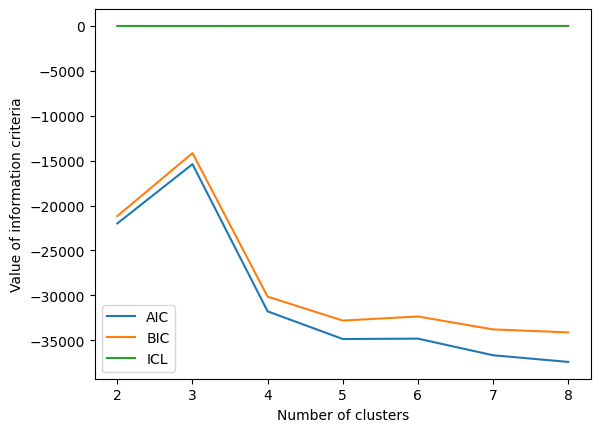

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Table:
[[  0. 338.   0.]
 [ 15.  15. 467.]
 [537.  79.   2.]]
Table using kmeans labels for mixture model:
[[308.  30.   0.]
 [ 13.  17. 467.]
 [ 42. 574.   2.]]
Log Likelihood for mixture model with kmeans labels: 7.530976057138591
Log Likelihood for best mixture model: 8.881128902249356


In [114]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Set seed
np.random.seed(1234)

# StepFlexmix (Equivalent to selecting the best GMM based on AIC, BIC, or ICL)
aic_values = []
bic_values = []
icl_values = []
for n_clusters in range(2, 9):
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full')
    gmm.fit(MD_x)
    aic_values.append(gmm.aic(MD_x))
    bic_values.append(gmm.bic(MD_x))
    icl_values.append(gmm.lower_bound_)

best_n_clusters = np.argmin(icl_values) + 2

# Plot
plt.plot(range(2, 9), aic_values, label='AIC')
plt.plot(range(2, 9), bic_values, label='BIC')
plt.plot(range(2, 9), icl_values, label='ICL')
plt.xlabel('Number of clusters')
plt.ylabel('Value of information criteria')
plt.legend()
plt.show()

# Fit GMM with the best number of clusters
best_gmm = GaussianMixture(n_components=best_n_clusters, covariance_type='full')
best_gmm.fit(MD_x)

# Get clusters
MD_k4_labels = KMeans(n_clusters=best_n_clusters, random_state=1234).fit_predict(MD_x)
MD_m4_labels = best_gmm.predict(MD_x)

# Table
table = np.zeros((best_n_clusters, best_n_clusters))
for kmeans_label, mixture_label in zip(MD_k4_labels, MD_m4_labels):
    table[kmeans_label, mixture_label] += 1

print("Table:")
print(table)

# Fit mixture model using kmeans labels
kmeans_gmm = GaussianMixture(n_components=best_n_clusters, covariance_type='full', init_params='kmeans')
kmeans_gmm.fit(MD_x)

# Table
kmeans_mixture_labels = kmeans_gmm.predict(MD_x)
table_kmeans_mixture = np.zeros((best_n_clusters, best_n_clusters))
for kmeans_label, mixture_label in zip(MD_k4_labels, kmeans_mixture_labels):
    table_kmeans_mixture[kmeans_label, mixture_label] += 1

print("Table using kmeans labels for mixture model:")
print(table_kmeans_mixture)

# Log Likelihood
loglik_kmeans = kmeans_gmm.score(MD_x)
loglik_mixture = best_gmm.score(MD_x)
print("Log Likelihood for mixture model with kmeans labels:", loglik_kmeans)
print("Log Likelihood for best mixture model:", loglik_mixture)


5.3 Using Mixtures of Regression Models


      yummy  convenient  spicy  fattening  greasy  fast  cheap  tasty  \
0         0           1      0          1       0     1      1      0   
1         1           1      0          1       1     1      1      1   
2         0           1      1          1       1     1      0      1   
3         1           1      0          1       1     1      1      1   
4         0           1      0          1       1     1      1      0   
...     ...         ...    ...        ...     ...   ...    ...    ...   
1448      0           1      0          1       1     0      0      0   
1449      1           1      0          1       0     0      1      1   
1450      1           1      0          1       0     1      0      1   
1451      1           1      0          0       0     1      1      1   
1452      0           1      0          1       1     0      0      0   

      expensive  healthy  disgusting  
0             1        0           0  
1             1        0           0  
2     

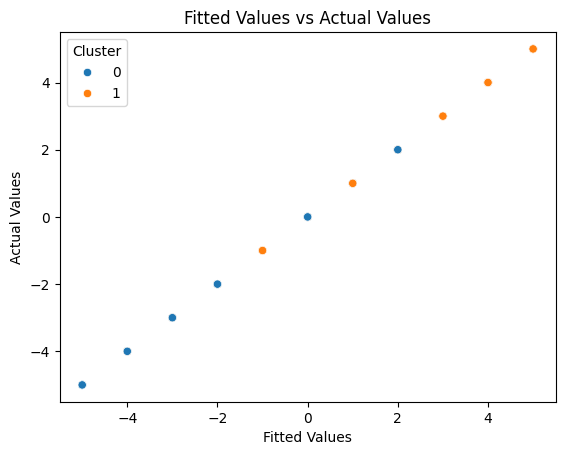

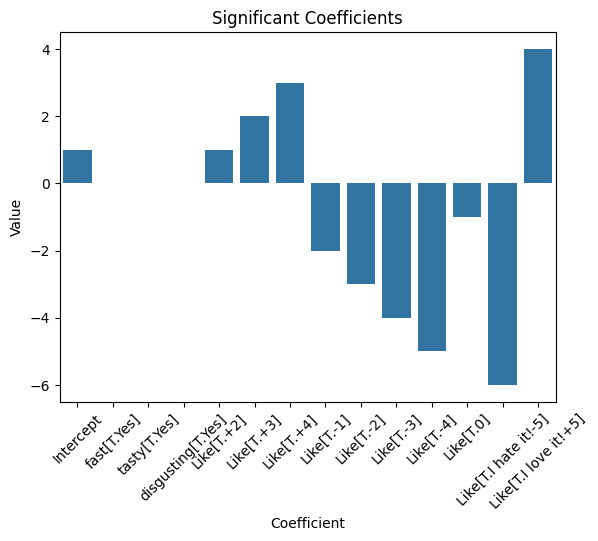

In [115]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.mixture import GaussianMixture


# Load the dataset
mcdonalds = pd.read_csv("https://homepage.boku.ac.at/leisch/MSA/datasets/mcdonalds.csv")  # Assuming the dataset is stored in a CSV file

# Extract numeric value from the 'Like' column using regular expressions
mcdonalds['Like_n'] = mcdonalds['Like'].str.extract(r'([-+]?\d+)').astype(float)

# Assuming mcdonalds is your DataFrame and 'Like.n' is the column
like_counts = mcdonalds['Like_n'].value_counts()
# print(like_counts)



# Assuming 'mcdonalds' is your DataFrame
predictor_variables = mcdonalds.columns[1:12]  # Assuming the first column is 'Like_n' and the next 11 columns are predictor variables
formula_string = " + ".join(predictor_variables)
formula_string = "Like_n ~ " + formula_string

f = smf.ols(formula=formula_string, data=mcdonalds)
print(f)




# Assuming 'f' is the formula and 'mcdonalds' is the DataFrame
# First, create a design matrix X and target vector y from the DataFrame
X = mcdonalds[['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting']]

# Convert non-numeric columns to numeric if possible
X = X.replace({"Yes": 1, "No": 0})
print(X)
y = mcdonalds['Like_n']

# Fit Gaussian Mixture Model (GMM)
n_components = 2  # Number of components (clusters)
gmm = GaussianMixture(n_components=n_components, n_init=10, random_state=1234)
gmm.fit(X)

# Predict cluster labels
cluster_labels = gmm.predict(X)

# Display the result
print(cluster_labels)


# Add cluster labels to the DataFrame
mcdonalds['cluster'] = cluster_labels

# Fit a regression model using statsmodels
model = sm.formula.ols(formula=formula_string, data=mcdonalds).fit()

# Summary of the model
print(model.summary())


import matplotlib.pyplot as plt
import seaborn as sns

# Assuming model is your fitted regression model obtained from statsmodels

# Plot the fitted values against the actual values
sns.scatterplot(x=model.fittedvalues, y=mcdonalds['Like_n'], hue=mcdonalds['cluster'])
plt.xlabel("Fitted Values")
plt.ylabel("Actual Values")
plt.title("Fitted Values vs Actual Values")
plt.legend(title='Cluster')
plt.show()

# Plot the coefficients with significance levels
coefficients = model.params
p_values = model.pvalues
significant_coefficients = coefficients[p_values < 0.05]  # Filter coefficients with p-value < 0.05
sns.barplot(x=significant_coefficients.index, y=significant_coefficients.values)
plt.xlabel("Coefficient")
plt.ylabel("Value")
plt.title("Significant Coefficients")
plt.xticks(rotation=45)
plt.show()


Step 6: Profiling Segments

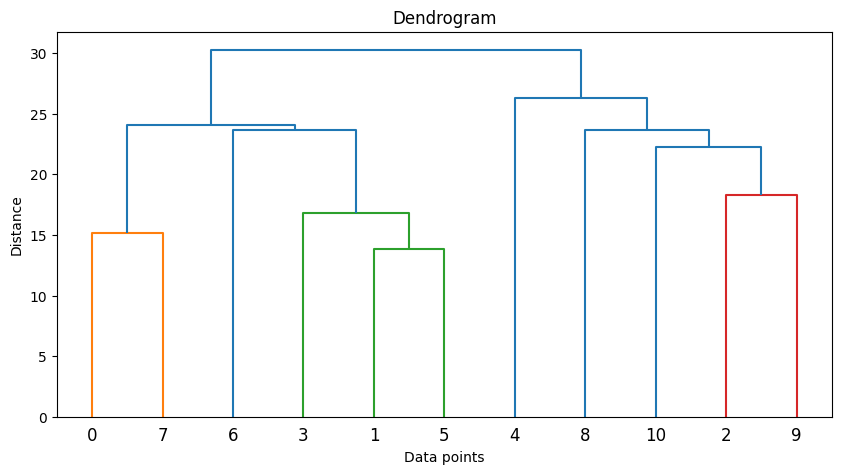

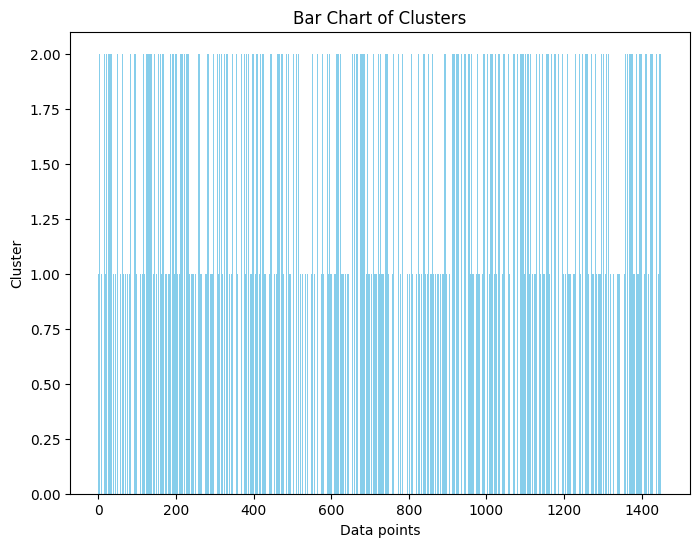

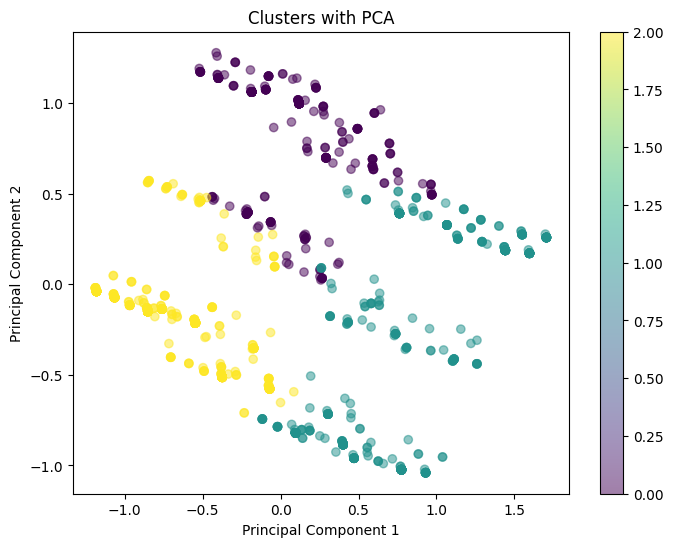

Principal component axes:
[[-0.47693349 -0.15533159 -0.00635636  0.11623168  0.3044427  -0.10849325
  -0.33718593 -0.47151394  0.32904173 -0.21371062  0.37475293]
 [ 0.36378978  0.016414    0.01880869 -0.03409395 -0.06383884 -0.0869722
  -0.61063276  0.3073178   0.60128596  0.07659344 -0.13965633]]


In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming 'MD.x' is your data matrix
# Perform hierarchical clustering
MD_vclust = hierarchy.linkage(MD_x.T, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 5))
hierarchy.dendrogram(MD_vclust)
plt.title('Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.show()

# Assuming 'MD_k4' is your KMeans clustering result with 4 clusters
# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(MD_k4_labels)), MD_k4_labels, color='skyblue')
plt.xlabel('Data points')
plt.ylabel('Cluster')
plt.title('Bar Chart of Clusters')
plt.show()

# Assuming 'MD_pca' is your PCA projection
# Project data onto principal components
pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x)

# Plot clusters with PCA
plt.figure(figsize=(8, 6))
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], c=MD_k4_labels, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters with PCA')
plt.colorbar()
plt.show()

# Principal component axes
print("Principal component axes:")
print(pca.components_)


Step 7: Describing Segments

0       0.333333
1       0.333333
2       0.333333
3       4.000000
4       1.000000
          ...   
1448    0.083333
1449    4.000000
1450    1.000000
1451    0.333333
1452    0.333333
Name: VisitFrequency, Length: 1453, dtype: float64


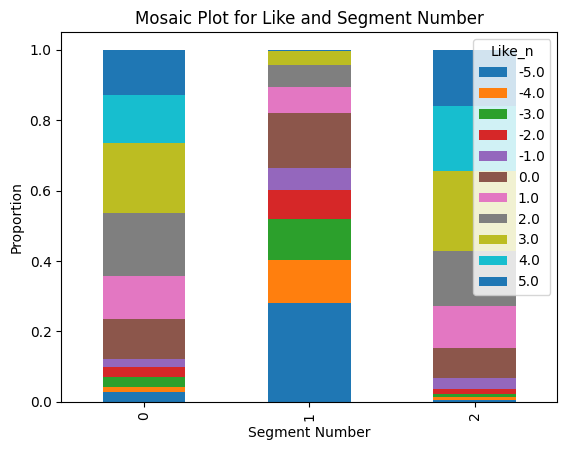

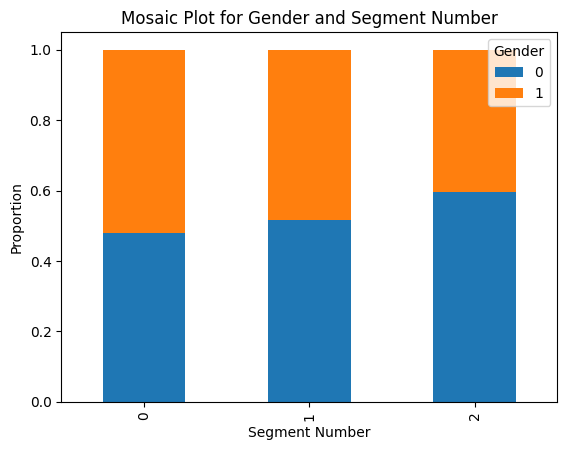

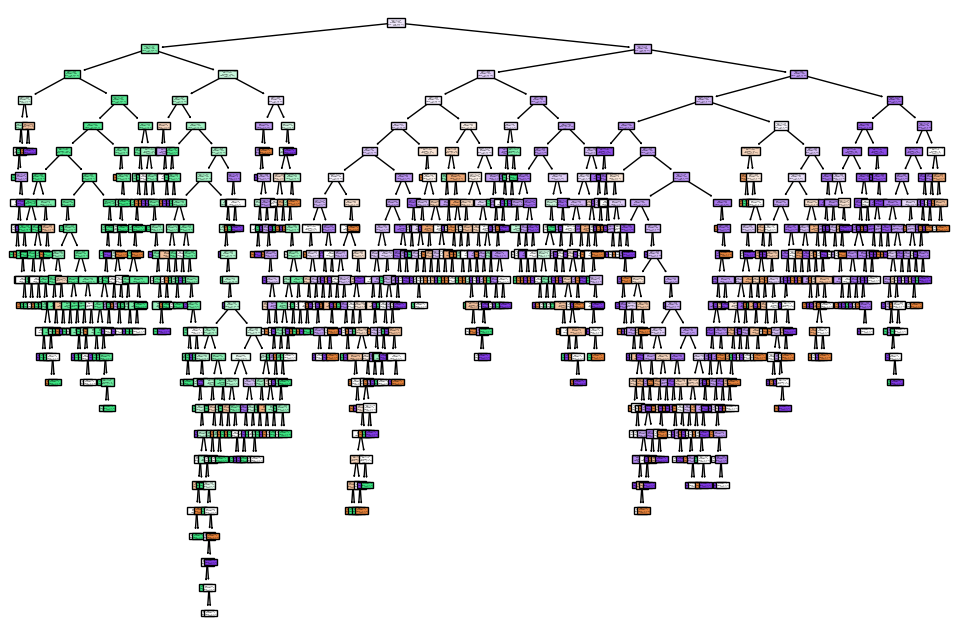

In [117]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder

# Load the dataset
mcdonalds = pd.read_csv("https://homepage.boku.ac.at/leisch/MSA/datasets/mcdonalds.csv")  # Assuming the dataset is stored in a CSV file

# Encode categorical variables like 'Gender'
label_encoder = LabelEncoder()
mcdonalds['Gender'] = label_encoder.fit_transform(mcdonalds['Gender'])

# Extract numeric value from the 'Like' column using regular expressions
mcdonalds['Like_n'] = mcdonalds['Like'].str.extract(r'([-+]?\d+)').astype(float)

mapping = {
    'Never': 0,
    'Once a year': 1/12,  # Assuming once a year means once in 12 months
    'Every three months': 1/3,
    'Once a month': 1,
    'Once a week': 4,  # Assuming once a week means once in 4 weeks
    'More than once a week': 10  # Or any other value you want to assign
}

# Replace values in the 'VisitFrequency' column using the mapping
mcdonalds['VisitFrequency'] = mcdonalds['VisitFrequency'].replace(mapping)
print(mcdonalds['VisitFrequency'])

# Get the clusters from MD.k4
k4 = MD_k4_labels

# Mosaic plot for Like and segment number (alternative)
pd.crosstab(k4, mcdonalds['Like_n']).apply(lambda r: r/r.sum(), axis=1).plot(kind='bar', stacked=True)
plt.xlabel("Segment Number")
plt.ylabel("Proportion")
plt.title("Mosaic Plot for Like and Segment Number")
plt.show()

# Mosaic plot for Gender and segment number (alternative)
pd.crosstab(k4, mcdonalds['Gender']).apply(lambda r: r/r.sum(), axis=1).plot(kind='bar', stacked=True)
plt.xlabel("Segment Number")
plt.ylabel("Proportion")
plt.title("Mosaic Plot for Gender and Segment Number")
plt.show()

mcdonalds['VisitFrequency'] = pd.to_numeric(mcdonalds['VisitFrequency'], errors='coerce')
# Fit a decision tree classifier
X = mcdonalds[['Like_n', 'Age', 'VisitFrequency', 'Gender']]
y = k4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
tree = DecisionTreeClassifier(random_state=1234)
tree.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=[str(i) for i in tree.classes_], filled=True)
plt.show()

Step 8: Selecting (the) Target Segment(s)

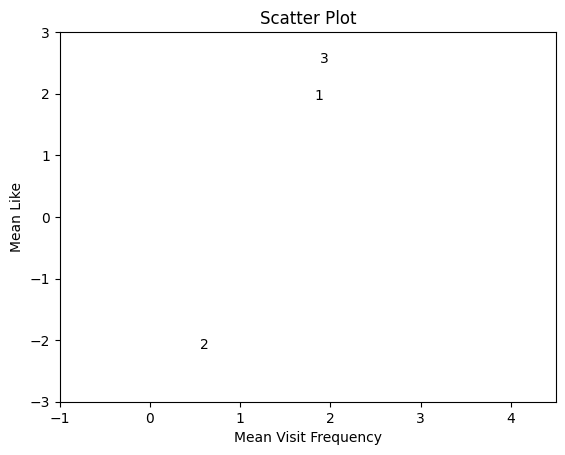

Number of unique cluster labels: 3
Unique cluster labels: [0 1 2]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'mcdonalds' is your DataFrame and 'k4' is the column with cluster labels
# 'VisitFrequency', 'Like.n', and 'Gender' are columns in the DataFrame

# Calculate mean VisitFrequency, Like.n, and female ratio by cluster label using groupby
visit = mcdonalds.groupby(k4)['VisitFrequency'].mean()
like = mcdonalds.groupby(k4)['Like_n'].mean()
female = mcdonalds.groupby(k4)['Gender'].apply(lambda x: (x == "Female").mean())

# Plot
plt.scatter(visit, like, s=50 * female, alpha=0.5)
plt.xlim(-1, 4.5)
plt.ylim(-3, 3)
plt.xlabel('Mean Visit Frequency')
plt.ylabel('Mean Like')
plt.title('Scatter Plot')
for i, (x, y) in enumerate(zip(visit, like)):
    plt.text(x, y, str(i + 1))

plt.show()

unique_labels = np.unique(k4)
print("Number of unique cluster labels:", len(unique_labels))
print("Unique cluster labels:", unique_labels)